In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Accelerated Data Science with Google Cloud and NVIDIA

| Authors |
| --- |
| Will Hill, Jeff Nelson |

## Overview

In this notebook, you will learn how to accelerate your data science and machine learning workflows on large datasets using NVIDIA CUDA-X for data science open-source libraries with Colab Enterprise.

You will build a machine learning pipeline to predict NYC taxi tip amounts. You will focus on accelerating `pandas` (using NVIDIA library `cuDF`), accelerating `scikit-learn` (using NVIDIA `cuML`), and training an XGBoost model on the GPU.

The best part? You can get this GPU acceleration with **zero code changes** to your existing `pandas` and `scikit-learn` code.

### Objectives

* Understand how to leverage a Colab Enterprise GPU-enabled runtime.
* Accelerate `pandas` with zero code changes using NVIDIA `cuDF`.
* Accelerate `scikit-learn` with zero code changes using NVIDIA `cuML`.
* Train an XGBoost model on the GPU.
* Compare the performance lift between CPU and GPU execution.

**Note:** This notebook is intended to run in Colab Enterprise with a [GPU-enabled runtime](https://docs.cloud.google.com/colab/docs/default-runtimes-with-gpus).

### Services and Costs

This tutorial uses the following billable components of Google Cloud:

*   **Colab Enterprise**: [Pricing](https://cloud.google.com/colab/pricing)
*   **Google Cloud Storage**: [Pricing](https://cloud.google.com/storage/pricing)

You can use the [Pricing Calculator](https://cloud.google.com/products/calculator) to generate a cost estimate based on your projected usage.

## Setup

**Note:** This notebook is intended to run in Colab Enterprise with a GPU-enabled runtime (e.g., T4, L4, A100, etc).

Let's start by verifying that a GPU is available in our runtime.

In [1]:
!nvidia-smi

Wed Feb 11 00:17:32 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   68C    P0             32W /   72W |    2041MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---

## Prepare the NYC taxi dataset

This tutorial uses the [NYC Taxi & Limousine Commission (TLC) Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

The dataset contains individual trip records from yellow taxis in New York City, and includes fields like:
*   Pick-up and drop-off dates, times, and locations
*   Trip distances
*   Itemized fare amounts
*   Passenger counts
*   **Tip amounts** (*the target variable we will predict*)

### Download the data

Next, download the trip data for all of 2024. The data is stored in the efficient, columnar Parquet file format. **Note:** We download the entire year so you have the option to experiment with a larger dataset later, but for the purpose of this tutorial, we will only load the first month's data to keep execution times fast.


In [2]:
from tqdm import tqdm
import requests
import time
import os

YEAR = 2024
DATA_DIR = "nyc_taxi_data"

os.makedirs(DATA_DIR, exist_ok=True)
print(f"Checking/Downloading files for {YEAR}...")

for month in tqdm(range(1, 13), unit="file"):
    file_name = f"yellow_tripdata_{YEAR}-{month:02d}.parquet"
    local_path = os.path.join(DATA_DIR, file_name)
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file_name}"

    if not os.path.exists(local_path):
        try:
            with requests.get(url, stream=True) as response:
                response.raise_for_status()
                with open(local_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            time.sleep(1)
        except requests.exceptions.HTTPError as e:
            print(f"\nSkipping {file_name}: {e}")
            if os.path.exists(local_path):
                os.remove(local_path)

print("\nDownload complete.")

Checking/Downloading files for 2024...


100%|██████████| 12/12 [00:00<00:00, 64445.13file/s]


Download complete.


---

## Accelerate pandas with NVIDIA cuDF

[NVIDIA CUDA for DataFrames (cuDF)](https://docs.rapids.ai/api/cudf/stable/) is an open-source, GPU-accelerated library that enables fast DataFrame operations.

By enabling `cudf.pandas`, your standard `pandas` code is **automatically redirected to use NVIDIA `cuDF` for pandas**. If an operation isn't supported on the GPU, it simply falls back to the CPU. And you get this without even changing your code!

To enable GPU acceleration, first load the `cudf.pandas` extension **before** importing `pandas`.

In [3]:
%load_ext cudf.pandas
import pandas as pd

pd # Note the output indicates cudf.pandas is active (ModuleAccelerator)

<module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>

**Note:** To ensure a clean environment, you may need to restart your kernel when switching between standard pandas and `cudf.pandas`.

### Load and Clean Data

Let's load the data we downloaded and clean out invalid trips (e.g., negative fares or distances, non-credit card payments where tips aren't tracked). Because `cudf.pandas` is active, this data loading and filtering happens on the GPU.

In [4]:
import time
import glob

# Start a timer so we can track performance
start_time = time.perf_counter()

# 1. Load data
df = pd.concat(
    [pd.read_parquet(f) for f in glob.glob("nyc_taxi_data/*-01.parquet")],
    ignore_index=True
)
print(f"Loaded {len(df):,} records.")

# 2. Clean data
df = df[
    (df['fare_amount'] > 0) & (df['fare_amount'] < 500) &
    (df['trip_distance'] > 0) & (df['trip_distance'] < 100) &
    (df['tip_amount'] >= 0) & (df['tip_amount'] < 100) &
    (df['payment_type'] == 1) # Credit card only (tips recorded)
].copy()


# 3. Downcast numeric columns to save memory
float_cols = df.select_dtypes(include=['float64']).columns
df[float_cols] = df[float_cols].astype('float32')
int_cols = df.select_dtypes(include=['int64']).columns
df[int_cols] = df[int_cols].astype('int32')

print(f"Clean records remaining: {len(df):,}.")

import gc
gc.collect()
print(f"Load and Clean Time: {time.perf_counter() - start_time:.2f} seconds")

Loaded 2,964,624 records.
Clean records remaining: 2,298,343.
Load and Clean Time: 2.29 seconds


### Feature Engineering

Next, we prepare our features for the machine learning models. We will extract time-based features, log-transform the fare, and create route-specific aggregations based on the pickup and dropoff location IDs.

Each of these vectorized operations are accelerated by the GPU.

In [5]:
import numpy as np

start_time = time.perf_counter()

# Time Features
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['dow'] = df['tpep_pickup_datetime'].dt.dayofweek
df['is_weekend'] = (df['dow'] >= 5).astype(int)
df['is_rush_hour'] = (
    ((df['hour'] >= 7) & (df['hour'] <= 9)) |
    ((df['hour'] >= 17) & (df['hour'] <= 19))
).astype(int)

# Amount Features
df['fare_log'] = np.log1p(df['fare_amount'])
df['fare_decimal'] = (df['fare_amount'] % 1 * 100).astype(int)
df['is_round_fare'] = (df['fare_amount'] % 5 == 0).astype(int)

# Route Features
df['route_id'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)
route_counts = df['route_id'].value_counts()
df['route_frequency'] = df['route_id'].map(route_counts)

# Location Aggregation Features (Mean and Std Tip by Pickup Location)
pu_tip_stats = df.groupby('PULocationID')['tip_amount'].agg(['mean', 'std']).reset_index()
pu_tip_stats.columns = ['PULocationID', 'pu_tip_mean', 'pu_tip_std']
df = df.merge(pu_tip_stats, on='PULocationID', how='left')

print(f"Feature Engineering Time: {time.perf_counter() - start_time:.2f} seconds")

Feature Engineering Time: 0.62 seconds


---

## Accelerate scikit-learn with NVIDIA cuML

Similar to how we accelerated `pandas`, NVIDIA provides CUDA-X for Machine Learing or cuML to accelerate `scikit-learn` functions (like Linear Regression, Random Forest, K-Means, PCA, etc.) dynamically.

Load `cuml.accel` to activate zero-code-change GPU-acceleration for `scikit-learn`.

*Note: The code below includes a brief compatibility fix to restore a missing utility in newer IPython versions required for the extension to load correctly.*

In [7]:
import IPython.core.magic
if not hasattr(IPython.core.magic, 'output_can_be_silenced'):
    IPython.core.magic.output_can_be_silenced = lambda x: x

%load_ext cuml.accel
import sys
print("cuml.accel active:", 'cuml.accel' in sys.modules)

cuml.accel active: True


### Prepare Features and Target

Let's select our feature columns (`x`) and define our target variable `tip_amount` (`y`). We will also set up a K-Fold cross-validator.

In [8]:
from sklearn.model_selection import KFold

feature_cols = [
    'trip_distance', 'fare_amount', 'passenger_count',
    'hour', 'dow', 'is_weekend', 'is_rush_hour',
    'fare_log', 'fare_decimal', 'is_round_fare',
    'route_frequency', 'pu_tip_mean', 'pu_tip_std',
    'PULocationID', 'DOLocationID'
]

X = df[feature_cols].fillna(-999)
y = df['tip_amount']

n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

---

## Train Individual Models with Cross-Validation

Now we will train three different predictive models to forecast tip amounts. We will use the standard `scikit-learn` API and NVIDIA `XGBoost`.

Because we loaded `cuml.accel`, some `scikit-learn` functions will execute on the GPU. For XGBoost to run on the GPU, we simply set `device='cuda'`.

### 1. XGBoost

XGBoost natively supports GPU backends. By configuring the `device` parameter to `"cuda"`, XGBoost leverages the GPU to train gradient-boosted trees significantly faster.

In [9]:
from tqdm.auto import tqdm
import xgboost as xgb
from sklearn.metrics import mean_squared_error

start_time = time.perf_counter()

def train_xgb_cv(X, y):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 5,
        'learning_rate': 0.1,
        'device': 'cuda',              # <--- Enable GPU Acceleration
        'verbosity': 0,
        'tree_method': 'hist',         # Explicit histogram method
        'max_bin': 256,                # Faster histogram binning
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'sampling_method': 'gradient_based'  # GPU-optimized sampling
    }

    rmses = []
    preds_all = np.zeros(len(y))

    for train_idx, val_idx in tqdm(kf.split(X), total=n_splits):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(params,
                          dtrain,
                          num_boost_round=1000,
                          evals=[(dval, 'val')],
                          early_stopping_rounds=50,
                          verbose_eval=False)

        preds = model.predict(dval)
        preds_all[val_idx] = preds
        rmses.append(np.sqrt(mean_squared_error(y_val, preds)))

    return np.mean(rmses), preds_all

xgb_rmse, xgb_preds = train_xgb_cv(X, y)
print(f"\n{'XGBoost RMSE:':<20} ${xgb_rmse:.4f}")
print(f"{'Time:':<20} {time.perf_counter() - start_time:.2f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]


XGBoost RMSE:        $2.2810
Time:                12.46 seconds


### 2. Linear Regression

Here we use the standard `sklearn.linear_model.LinearRegression` class. We also use `StandardScaler` to scale the features. Behind the scenes, `cuml.accel` intercepts these calls and executes them on the GPU using `cuML`.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

start_time = time.perf_counter()

def train_lingreg_cv(X, y):
    rmses = []
    preds_all = np.zeros(len(y))
    for train_idx, val_idx in tqdm(kf.split(X), total=n_splits):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Automatically accelerated by cuML
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)

        preds = model.predict(X_val_scaled)
        preds_all[val_idx] = preds
        rmses.append(np.sqrt(mean_squared_error(y_val, preds)))

    return np.mean(rmses), preds_all

linreg_rmse, linreg_preds = train_lingreg_cv(X, y)
print(f"\n{'Linear Reg RMSE:':<20} ${linreg_rmse:.4f}")
print(f"{'Time:':<20} {time.perf_counter() - start_time:.2f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]


Linear Reg RMSE:     $2.4439
Time:                19.13 seconds


### 3. Random Forest

We can also use a complex ensemble model like Random Forest. Tree-based models are traditionally slow to train on the CPU, but with GPU acceleration, millions of rows can be processed much quicker.

In [11]:
from sklearn.ensemble import RandomForestRegressor

start_time = time.perf_counter()

def train_rf_cv(X, y):
    rmses = []
    preds_all = np.zeros(len(y))
    for train_idx, val_idx in tqdm(kf.split(X), total=n_splits):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Automatically accelerated by cuML
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            n_jobs=-1,
            max_features='sqrt',
            random_state=42
        )
        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        preds_all[val_idx] = preds
        rmses.append(np.sqrt(mean_squared_error(y_val, preds)))

    return np.mean(rmses), preds_all

rf_rmse, rf_preds = train_rf_cv(X, y)
print(f"\n{'Random Forest RMSE:':<20} ${rf_rmse:.4f}")
print(f"{'Time:':<20} {time.perf_counter() - start_time:.2f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]


Random Forest RMSE:  $2.3142
Time:                16.12 seconds


---

## Evaluate the End-to-End Pipeline

Finally, let's combine the predictions from our three models using a simple linear ensemble. This often provides a slight accuracy lift.

In [12]:
# Fit a linear regression on the predictions to find optimal weights
ensemble_weights = LinearRegression(positive=True, fit_intercept=False).fit(
    np.c_[xgb_preds, rf_preds, linreg_preds], y
).coef_

# Normalize weights
ensemble_weights = ensemble_weights / ensemble_weights.sum()

ensemble_preds = np.c_[xgb_preds, rf_preds, linreg_preds] @ ensemble_weights
ensemble_rmse = np.sqrt(mean_squared_error(y, ensemble_preds))

print(f"\n{'Model':<20} {'RMSE':>10}")
print("-" * 32)
print(f"{'Linear Regression':<20} ${linreg_rmse:>9.4f}")
print(f"{'Random Forest':<20} ${rf_rmse:>9.4f}")
print(f"{'XGBoost':<20} ${xgb_rmse:>9.4f}")
print("-" * 32)
print(f"{'Ensemble':<20} ${ensemble_rmse:>9.4f}")
print(f"\nEnsemble lift: ${xgb_rmse - ensemble_rmse:.4f}")


Model                      RMSE
--------------------------------
Linear Regression    $   2.4439
Random Forest        $   2.3142
XGBoost              $   2.2810
--------------------------------
Ensemble             $   2.2796

Ensemble lift: $0.0014


---

## Compare CPU vs. GPU performance

To properly measure the performance difference, you'll first run an end-to-end data science pipeline on the CPU, and then run it again on the GPU.

**First, restart the kernel** to ensure you start with a clean execution state.

In [8]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Define the data science pipeline

Next, wrap the core workflow (loading data, cleaning, feature engineering, and model training) into a single function. This function allows us to pass in standard `pandas` or GPU-accelerated `cudf.pandas`, and toggle the XGBoost `device`.

In [ ]:
def run_ml_pipeline(pd_module, use_gpu=False):
    import time
    import glob
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    import xgboost as xgb

    timings = {}

    # 1. Load Data
    t0 = time.perf_counter()
    df = pd_module.concat(
        [pd_module.read_parquet(f) for f in glob.glob("nyc_taxi_data/*-01.parquet")],
        ignore_index=True
    )
    timings['Load Data'] = time.perf_counter() - t0

    # 2. Clean Data
    t0 = time.perf_counter()
    df = df[
        (df['fare_amount'] > 0) & (df['fare_amount'] < 500) &
        (df['trip_distance'] > 0) & (df['trip_distance'] < 100) &
        (df['tip_amount'] >= 0) & (df['tip_amount'] < 100) &
        (df['payment_type'] == 1)
    ].copy()

    # Downcast numeric columns to save memory
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    timings['Clean Data'] = time.perf_counter() - t0

    # 3. Feature Engineering
    t0 = time.perf_counter()
    df['hour'] = df['tpep_pickup_datetime'].dt.hour
    df['dow'] = df['tpep_pickup_datetime'].dt.dayofweek
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    df['fare_log'] = np.log1p(df['fare_amount'])
    timings['Feature Engineering'] = time.perf_counter() - t0

    # 4. Modeling Prep
    feature_cols = ['trip_distance', 'fare_amount', 'passenger_count', 'hour', 'dow', 'is_weekend', 'fare_log']
    X = df[feature_cols].fillna(-999)
    y = df['tip_amount'].copy()

    # Free memory we no longer need
    del df
    import gc
    gc.collect()

    # 5. Train Random Forest
    t0 = time.perf_counter()
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        n_jobs=-1,
        max_features='sqrt',
        random_state=42
    ).fit(X, y)
    timings['Train Random Forest'] = time.perf_counter() - t0

    # 6. Train XGBoost
    t0 = time.perf_counter()
    # Use DMatrix for optimal performance
    dtrain = xgb.DMatrix(X, label=y)

    # Free memory we no longer need
    del X
    del y
    gc.collect()
    params = {'objective': 'reg:squarederror', 'max_depth': 5}
    if use_gpu:
        params['device'] = 'cuda'
        params['tree_method'] = 'hist'
    xgb_model = xgb.train(params, dtrain, num_boost_round=100)
    timings['Train XGBoost'] = time.perf_counter() - t0

    return timings

### Run on your CPU

Call the pipeline using standard `pandas` and `scikit-learn` (the CPU defaults).

In [2]:
import pandas as pd

print("Running pipeline on CPU...")
cpu_times = run_ml_pipeline(pd, use_gpu=False)
print("CPU Execution Finished.")

Running pipeline on CPU...
CPU Execution Finished.


### Run on your GPU

Now, load the NVIDIA library extensions. You will pass the accelerated `cudf.pandas` module into the pipeline, and set your XGBoost device to `cuda`.

In [3]:
import IPython.core.magic
if not hasattr(IPython.core.magic, 'output_can_be_silenced'):
    IPython.core.magic.output_can_be_silenced = lambda x: x

%load_ext cudf.pandas
%load_ext cuml.accel
import pandas as gpu_pd

print("Running pipeline on GPU...")
gpu_times = run_ml_pipeline(gpu_pd, use_gpu=True)
print("GPU Execution Finished.")

Running pipeline on GPU...
GPU Execution Finished.


### Visualize the performance speedup

With both benchmarks complete, you can visualize the execution timings side-by-side using `matplotlib`.

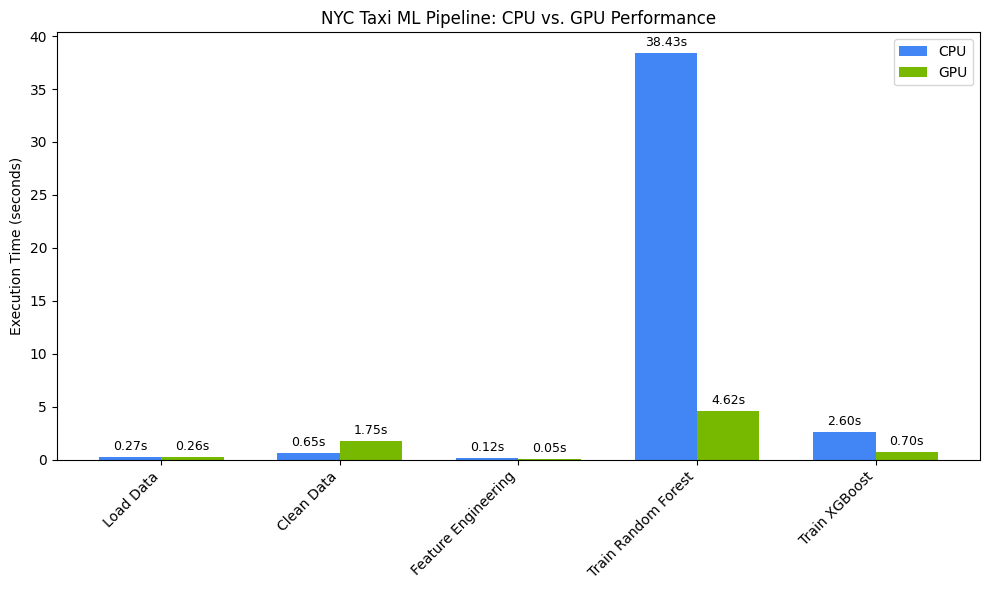


Overall Pipeline Speedup: 5.70x faster on GPU!


In [4]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(cpu_times.keys())
cpu_values = list(cpu_times.values())
gpu_values = list(gpu_times.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, cpu_values, width, label='CPU', color='#4285F4')
rects2 = ax.bar(x + width/2, gpu_values, width, label='GPU', color='#76B900')

ax.set_ylabel('Execution Time (seconds)')
ax.set_title('NYC Taxi ML Pipeline: CPU vs. GPU Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Add data labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}s',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# Calculate overall speedup
total_cpu_time = sum(cpu_values)
total_gpu_time = sum(gpu_values)
overall_speedup = total_cpu_time / total_gpu_time
print(f"\nOverall Pipeline Speedup: {overall_speedup:.2f}x faster on GPU!")

---

## Profile your code to find bottlenecks

When using `cudf.pandas`, most functions run on the GPU. But if a specific operation is not yet supported by cuDF, the execution temporarily falls back to the CPU. Identifying these fallbacks is crucial for achieving maximum performance.

NVIDIA provides two built-in Jupyter magic commands for this purpose: `%%cudf.pandas.profile` and `%%cudf.pandas.line_profile`.

### High-level profiling with `%%cudf.pandas.profile`

The `%%cudf.pandas.profile` magic command provides a detailed summary of your code block, showing exactly which pandas functions were called, how many times they ran, and whether they executed on the GPU or fell back to the CPU.

In [5]:
%%cudf.pandas.profile

import glob
import pandas as pd

df = pd.concat([pd.read_parquet(f) for f in glob.glob("nyc_taxi_data/*-01.parquet")], ignore_index=True)

summary = (
    df
      .groupby(['PULocationID', 'payment_type'])
      [['passenger_count', 'fare_amount', 'tip_amount']]
      .agg(['min', 'mean', 'max'])
)

                                                                                                                  
                                            Total time elapsed: 0.589 seconds                                     
                                          5 GPU function calls in 0.144 seconds                                   
                                          0 CPU function calls in 0.000 seconds                                   
                                                                                                                  
                                                          Stats                                                   
                                                                                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                     ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ read_parquet                 │ 1          │ 0.055       │ 0.055       │ 0          │ 0.000       │ 0.000       │
│ concat                       │ 1          │ 0.014       │ 0.014       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.groupby            │ 1          │ 0.027       │ 0.027       │ 0          │ 0.000       │ 0.000       │
│ DataFrameGroupBy.__getitem__ │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ DataFrameGroupBy.aggregate   │ 1          │ 0.041       │ 0.041       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

### Line-by-line profiling with `%%cudf.pandas.line_profile`

To find exactly where CPU execution is slowing you down, you can use the more granular `%%cudf.pandas.line_profile`.

Below, we write an intentionally inefficient operation (using `df.apply` to categorize an hour of the day) and view the line-by-line profile.

In [7]:
%%cudf.pandas.line_profile

import glob
import pandas as pd

df = pd.concat([pd.read_parquet(f) for f in glob.glob("nyc_taxi_data/*-01.parquet")], ignore_index=True)
df = df.sample(1_000)

# 1. INAFFICIENT: Iterating row-by-row or using custom python apply functions often
# falls back to the CPU, severely bottlenecking your performance.
def categorize_hour(hour):
    if hour < 12:
        return 'Morning'
    else:
        return 'Afternoon/Evening'

df['hour'] = df['tpep_pickup_datetime'].dt.hour

# This line will show CPU fallback because of .apply()
df['time_of_day_slow'] = df['hour'].apply(categorize_hour)

# 2. EFFICIENT: Using vectorized pandas operations (like pd.cut) stays entirely on the GPU
cut_bins = [-1, 11, 24]
cut_labels = ['Morning', 'Afternoon/Evening']

# This line stays completely on the GPU
df['time_of_day_fast'] = pd.cut(df['hour'], bins=cut_bins, labels=cut_labels)

                                                                                                                   
                                            Total time elapsed: 93.234 seconds                                     
                                                                                                                   
                                                           Stats                                                   
                                                                                                                   
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Line no. ┃ Line                                                                     ┃ GPU TIME(s) ┃ CPU TIME(s) ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 2        │     import glob                                                          │             │             │
│          │                                                                          │             │             │
│ 3        │     import pandas as pd                                                  │             │             │
│          │                                                                          │             │             │
│ 5        │     df = pd.concat([pd.read_parquet(f) for f in glob.glob("nyc_taxi_dat… │ 0.106230757 │             │
│          │                                                                          │             │             │
│ 6        │     df = df.sample(1_000)                                                │ 0.038868650 │             │
│          │                                                                          │             │             │
│ 10       │     def categorize_hour(hour):                                           │             │             │
│          │                                                                          │             │             │
│ 11       │         if hour < 12:                                                    │             │             │
│          │                                                                          │             │             │
│ 12       │             return 'Morning'                                             │             │             │
│          │                                                                          │             │             │
│ 14       │             return 'Afternoon/Evening'                                   │ 0.009402969 │ 0.000643506 │
│          │                                                                          │             │             │
│ 16       │     df['hour'] = df['tpep_pickup_datetime'].dt.hour                      │ 0.006006393 │             │
│          │                                                                          │             │             │
│ 19       │     df['time_of_day_slow'] = df['hour'].apply(categorize_hour)           │ 0.001345225 │             │
│          │                                                                          │             │             │
│ 22       │     cut_bins = [-1, 11, 24]                                              │             │             │
│          │                                                                          │             │             │
│ 23       │     cut_labels = ['Morning', 'Afternoon/Evening']                        │             │             │
│          │                                                                          │             │             │
│ 26       │     df['time_of_day_fast'] = pd.cut(df['hour'], bins=cut_bins, labels=c… │ 0.018630019 │             │
│          │                                                                          │             │             │
└──────────┴────────────────────────────────────────────

---

## Clean Up

To avoid incurring unexpected charges to your Google Cloud account, you need to clean up the resources you created.

### Delete resources

The following code permanently deletes the locally downloaded NYC taxi dataset.

In [ ]:
# Remove NYC taxi dataset on the Colab runtime
print("Deleting local 'nyc_taxi_data' directory...")
!rm -rf nyc_taxi_data
print("Local files deleted.")

### Shut down your Colab runtime

* In the Google Cloud console, go to the Colab Enterprise **Runtimes** page.
* In the **Region** menu, select the region that contains your runtime.
* Select the runtime you want to delete.
* Click **Delete**.
* Click **Confirm**.

### Delete your Notebook

* In the Google Cloud console, go to the Colab Enterprise **My Notebooks** page.
* In the **Region** menu, select the region that contains your notebook.
* Select the notebook you want to delete.
* Click **Delete**.
* Click **Confirm**.

---

## Recap

Congratulations! You've successfully accelerated a pandas and scikit-learn machine learning workflow using NVIDIA cuDF and cuML on Colab Enterprise. By simply adding a few magic commands (`%load_ext cudf.pandas` and `%load_ext cuml.accel`), your standard `pandas` and `scikit-learn` code runs on the GPU, processing millions of rows and fitting complex models in seconds instead of minutes.

### Reference docs

* [Colab Enterprise Documentation](https://cloud.google.com/colab/docs/introduction)
* [NVIDIA cuDF Documentation](https://docs.rapids.ai/api/cudf/stable/)
* [NVIDIA cuML Documentation](https://docs.rapids.ai/api/cuml/stable/)